In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../scripts/optlevstyle.mplstyle')
import data_processing as dp
import plotting as pl
from importlib import reload
import h5py
import getpass

### Choose the bead and dataset

In [3]:
date = '20231109'
dataset = '1'

### Find the diagonalization matrix for the chosen dataset

Loading data from 21 files...


100%|██████████| 21/21 [00:00<00:00, 1995.34it/s]


Successfully loaded 21 files.
Building dictionary of file data...
Done building dictionary.
Binning data by mean cantilever position and accelerometer data...
Done binning data.
Fraction of power in imaginary parts to be discarded:
Q1: 0.000, Q2: 0.000, Q3: 0.004, Q4: 0.002
Diagonalization complete!
Copy the following into the config.yaml files for the relevant datasets:
qpd_diag_mat: [[-0.22671565,-0.76002535,-0.11096045,1.09770145],[0.65632753,-0.15063573,0.36859667,-0.87428847],[0.65732006,0.42434143,0.02879220,0.43247623],[2.54834212,1.64511507,0.11162352,1.67665261]]


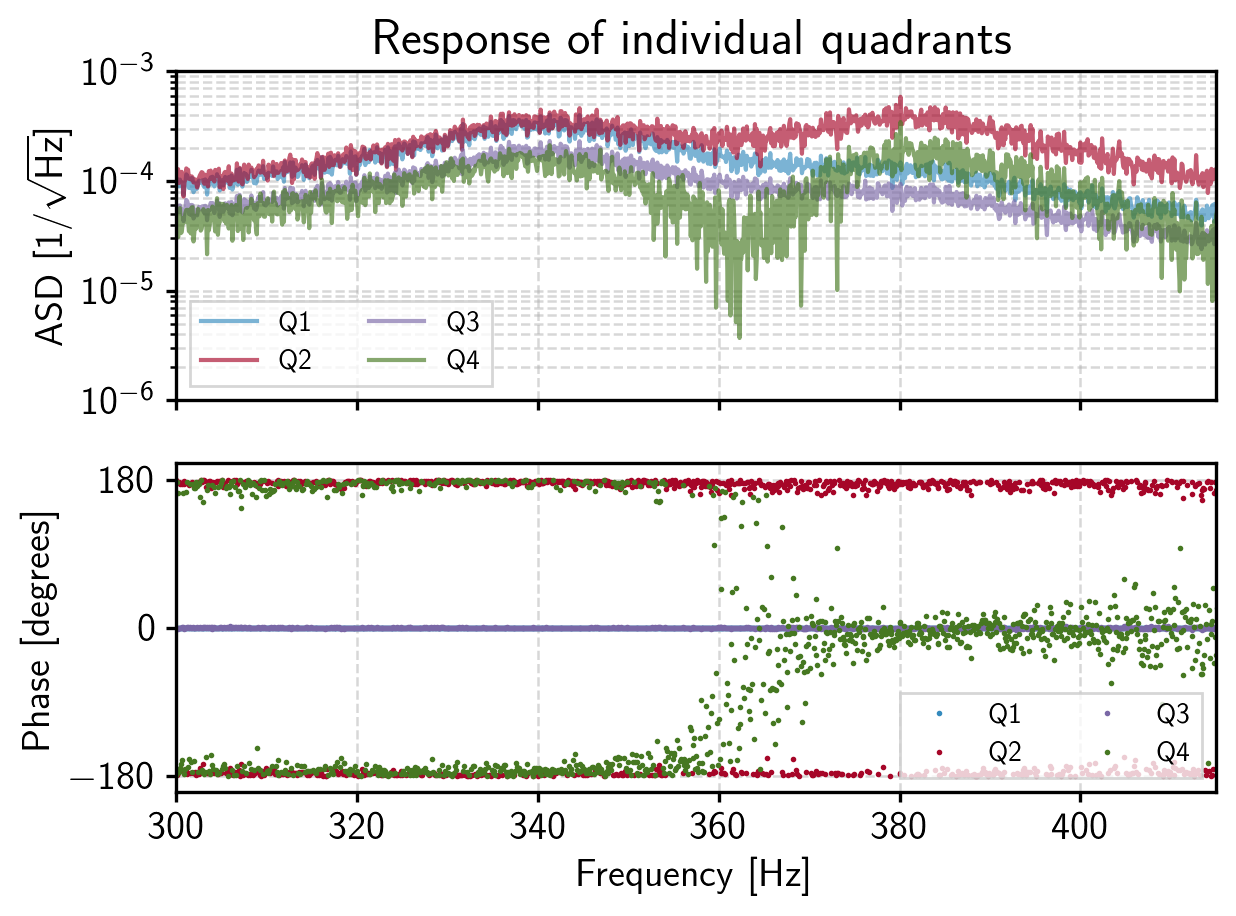

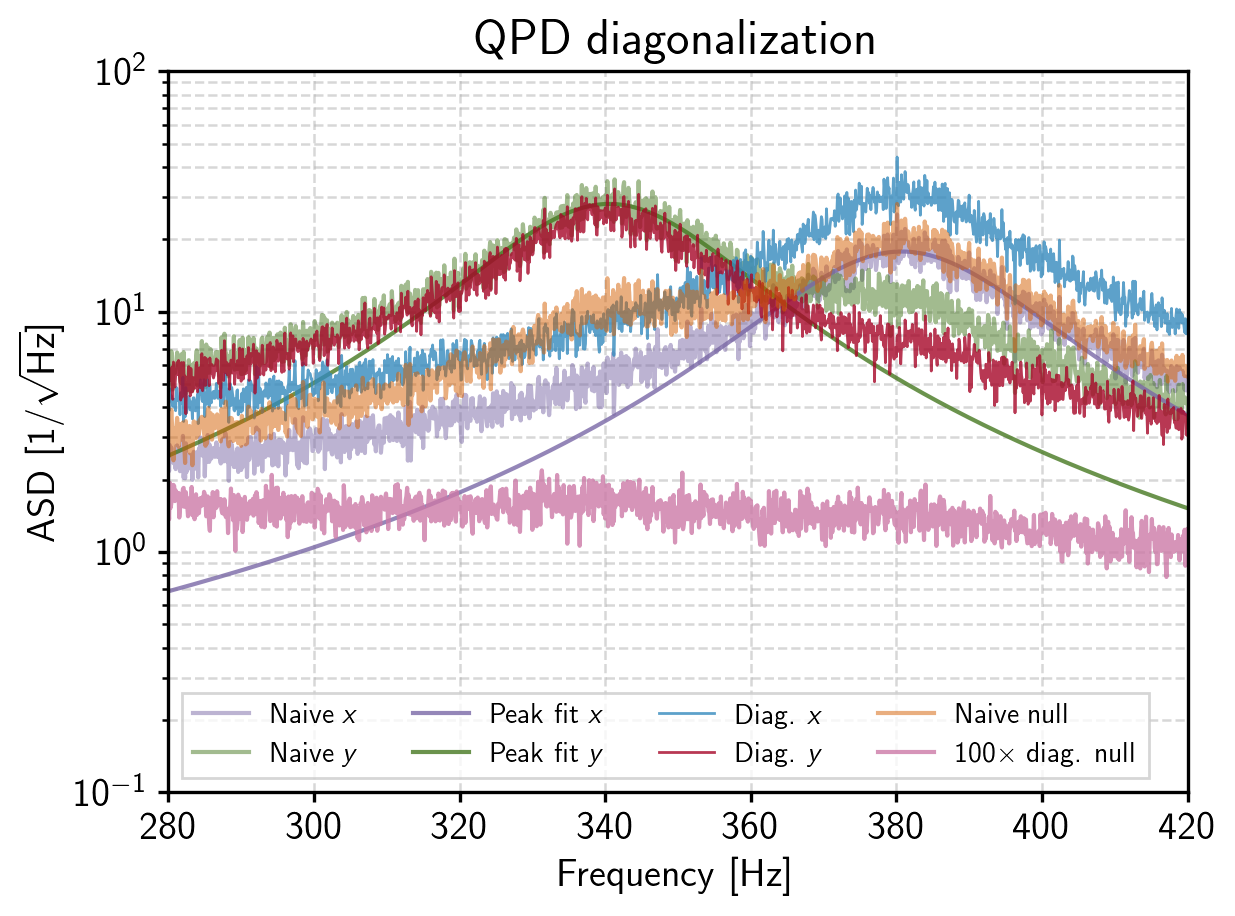

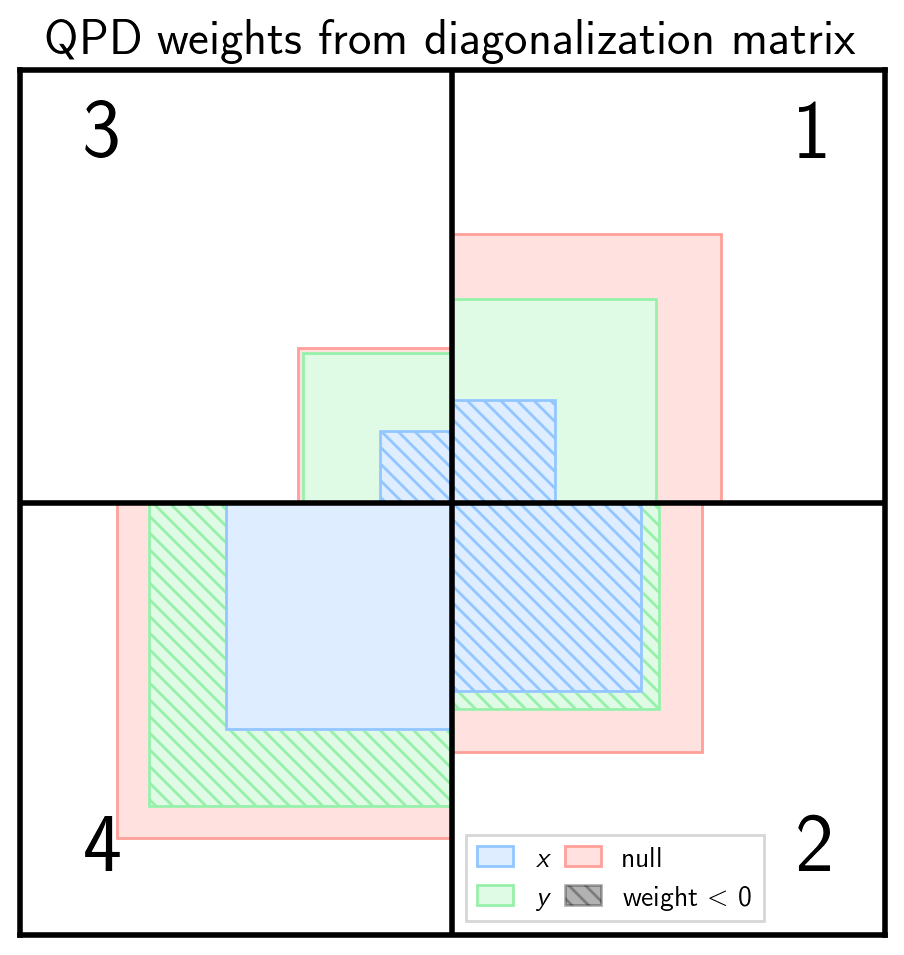

In [4]:
if date=='20231009':
    peak_guess = [380,315]
elif date=='20231109':
    peak_guess = [375,340]
elif date=='20231127':
    peak_guess = [400,350]
elif date=='20231005':
    peak_guess = [360,300]

config = {'p0_bead': [0,0,0], 'diam_bead': 0, 'mass_bead': 0}
aggdat = dp.AggregateData(['/data/new_trap/{}/Bead0/QPDdiag/1/'.format(date)],\
                          ['shaking_'],descrips=['qpd_diag',],num_to_load=100,configs=config)
aggdat.load_file_data(num_cores=30,no_tf=True,downsample=False,lightweight=False,max_freq=2500.)
aggdat.bin_by_aux_data()
qpd_diag_mat = aggdat.diagonalize_qpd(plot=True,peak_guess=peak_guess)

config = {'p0_bead': [0,0,0], 'diam_bead': 0, 'mass_bead': 0, 'qpd_diag_mat': qpd_diag_mat}

### Load the TF data with and without diagonalization

In [5]:
reload(dp)

aggdat_naiv = dp.AggregateData(['/data/new_trap/{}/Bead0/TransFunc/trapFocus/{}/'.format(date,dataset)]*3,['TF_X_','TF_Y_','TF_Z_'],\
                               ['x','y','z'],num_to_load=1,configs=config)
aggdat_naiv.load_file_data(num_cores=39,load_templates=False,no_tf=True,harms=[1],\
                           diagonalize_qpd=False,downsample=False,max_freq=2500.)

aggdat_diag = dp.AggregateData(['/data/new_trap/{}/Bead0/TransFunc/trapFocus/{}/'.format(date,dataset)]*3,['TF_X_','TF_Y_','TF_Z_'],\
                               ['x','y','z'],num_to_load=1,configs=config)
aggdat_diag.load_file_data(num_cores=39,load_templates=False,no_tf=True,harms=[1],\
                           diagonalize_qpd=True,downsample=False,max_freq=2500.)

Loading data from 3 files...


100%|██████████| 3/3 [00:00<00:00, 14.59it/s]
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Successfully loaded 3 files.
Building dictionary of file data...
Done building dictionary.
Loading data from 3 files...


100%|██████████| 3/3 [00:00<00:00, 2448.51it/s]
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clarkeh/.conda/envs/clarkeh/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Successfully loaded 3 files.
Building dictionary of file data...
Done building dictionary.


### Plot the raw TF data in counts before and after

Text(0.5, 0.98, 'Transfer function data before and after diagonalization')

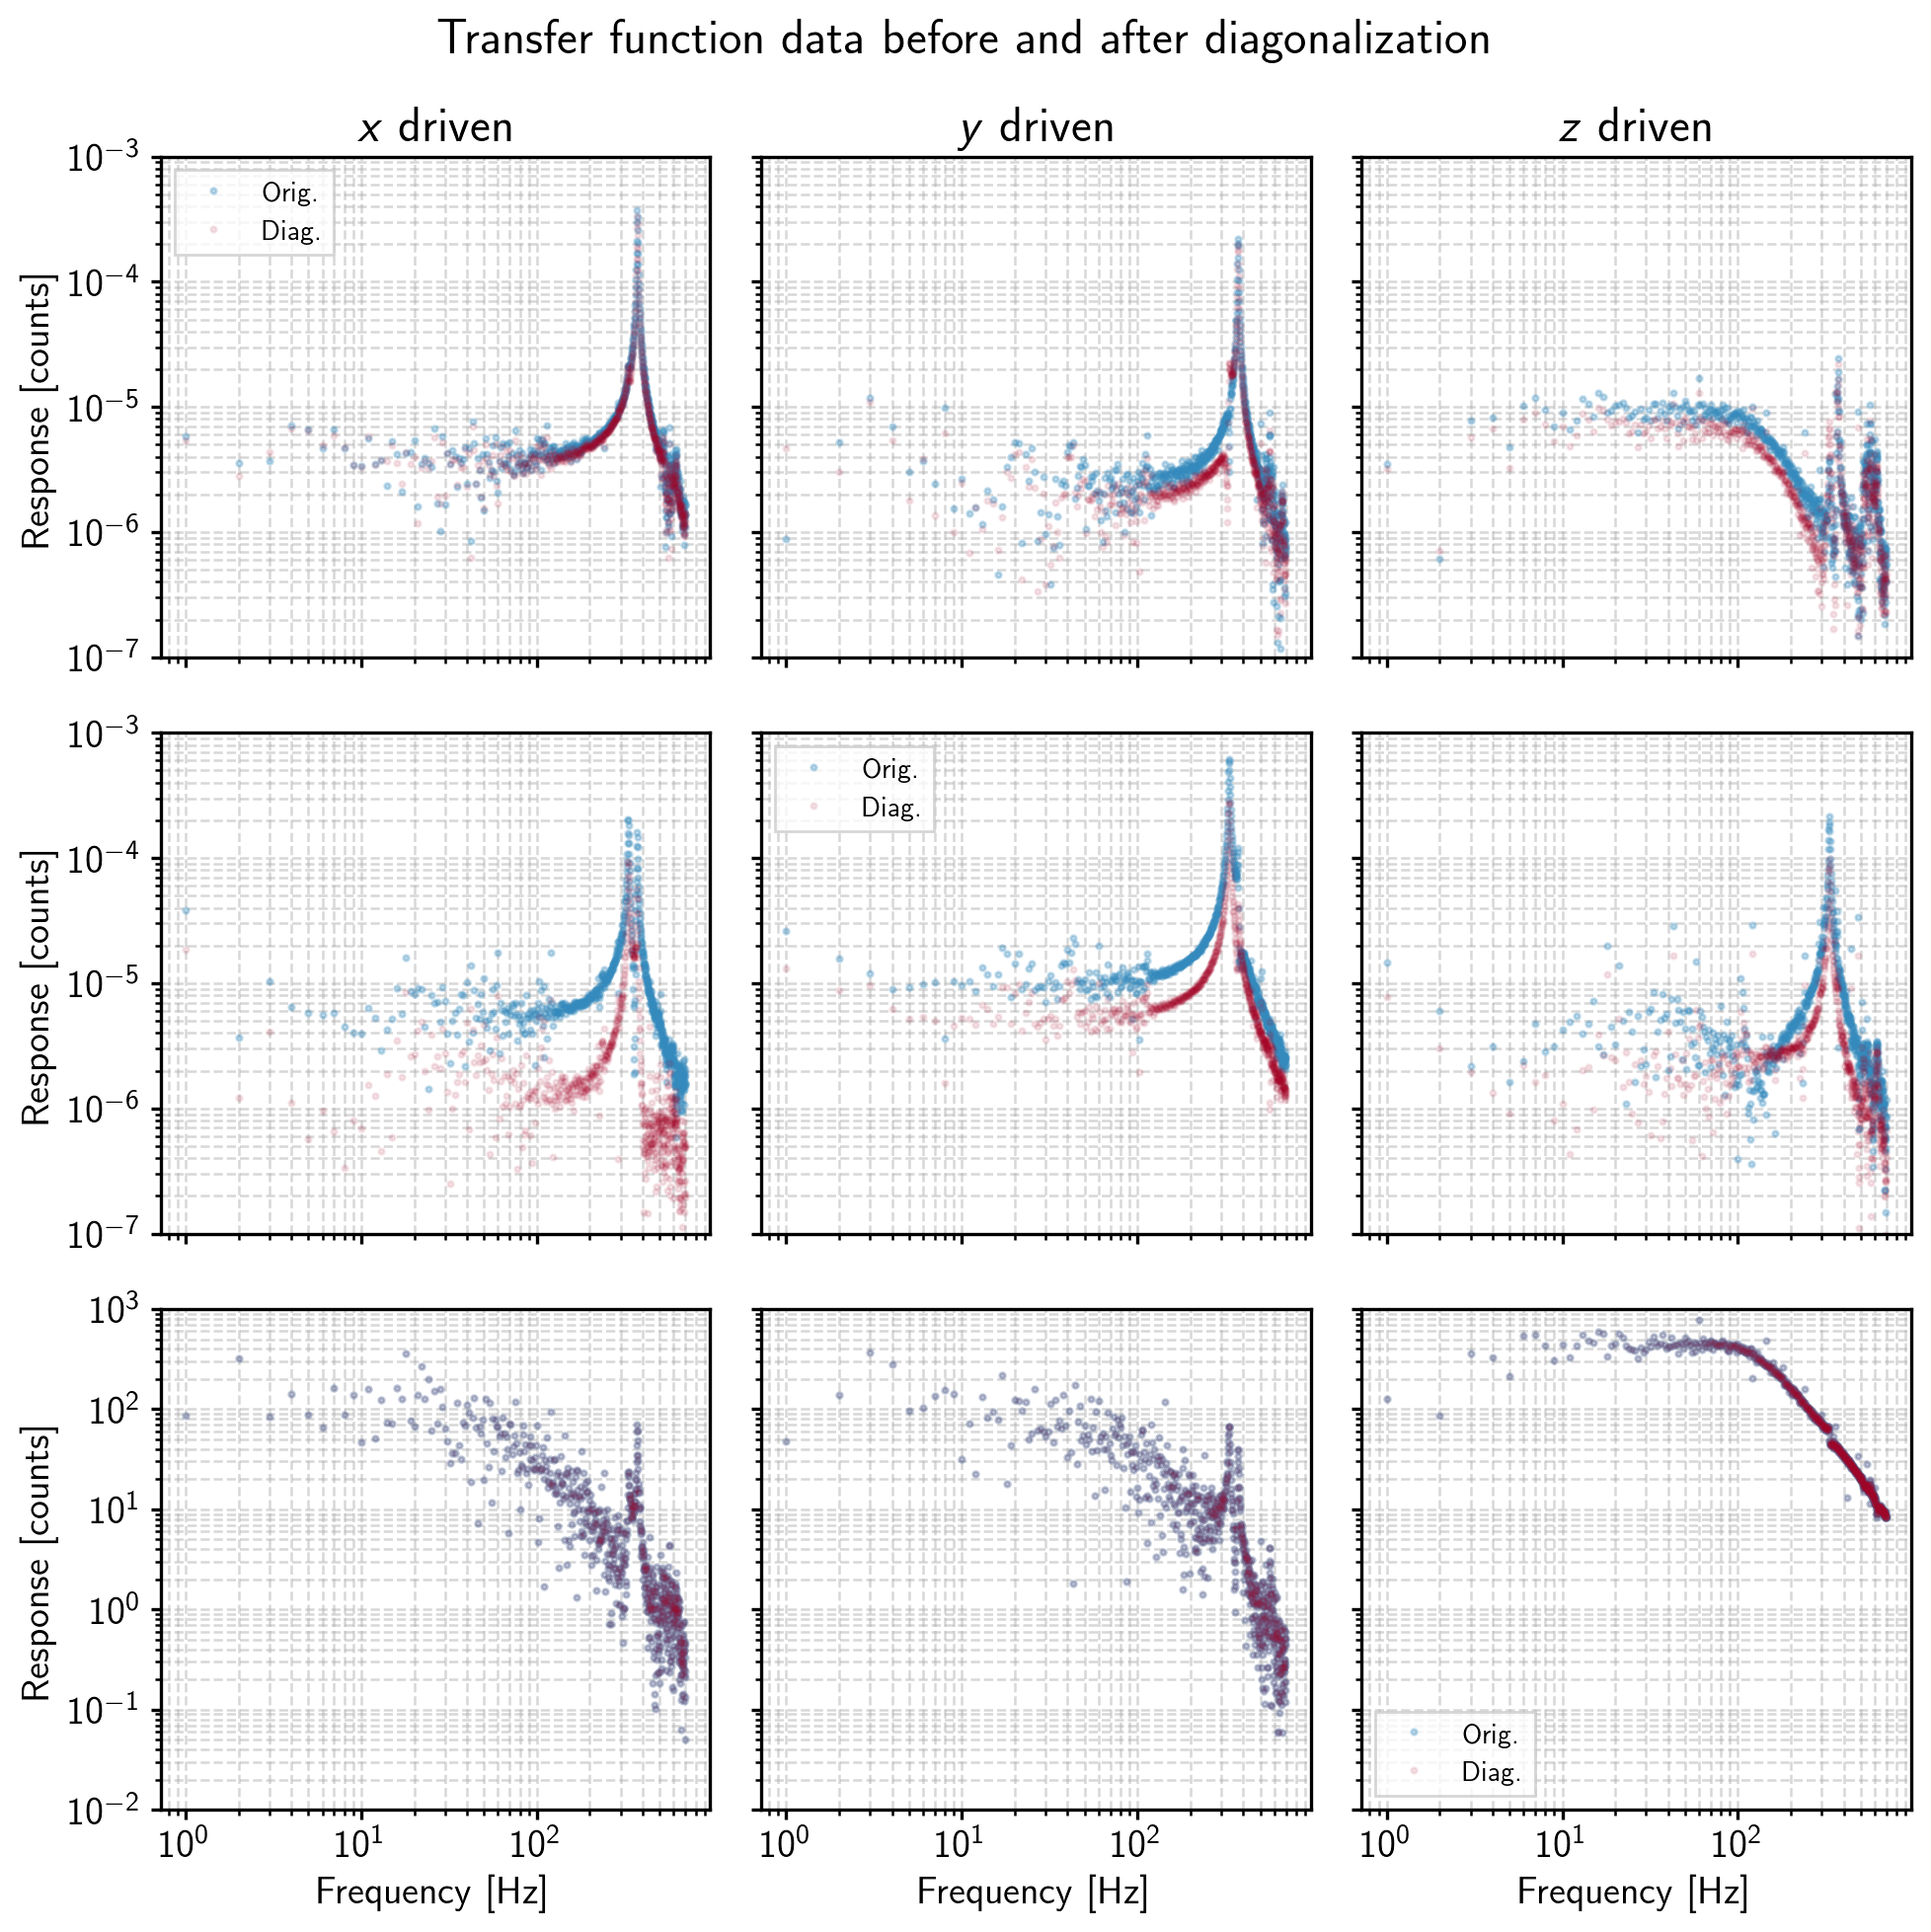

In [6]:
freqs = np.arange(1,700)
freqs_all = aggdat_naiv.agg_dict['freqs']
freq_inds = np.array([np.argmin(np.abs(freqs_all-f)) for f in freqs])
flat_inds = freq_inds[(freqs_all[freq_inds]>10) & (freqs_all[freq_inds]<100)]
titles = ['$x$ driven','$y$ driven','$z$ driven']

fig,ax = plt.subplots(3,3,figsize=(10,10),sharex=True,sharey='row')

# i indexes the drive
for i in range(3):
    # j indexes the response
    for j in range(3):
        ax[j,i].loglog(freqs,np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.3,lw=0.5,ls='none',marker='o',ms=2,label='Orig.')
        ax[j,i].loglog(freqs,np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.1,lw=0.5,ls='none',marker='o',ms=2,label='Diag.')
        if j<2:
            ax[j,i].set_ylim([1e-7,1e-3])
            if j==0:
                ax[j,i].set_title(titles[i])
        else:
            ax[j,i].set_ylim([1e-2,1e3])
            ax[j,i].set_xlabel('Frequency [Hz]')
        if i==0:
            ax[j,i].set_ylabel('Response [counts]')
        ax[j,i].grid(which='both')
    ax[i,i].legend()
fig.suptitle('Transfer function data before and after diagonalization')

### Calculate the scaling factors to match the 10-150 Hz level in counts

Text(0.5, 0.98, 'Transfer function data scaled to match')

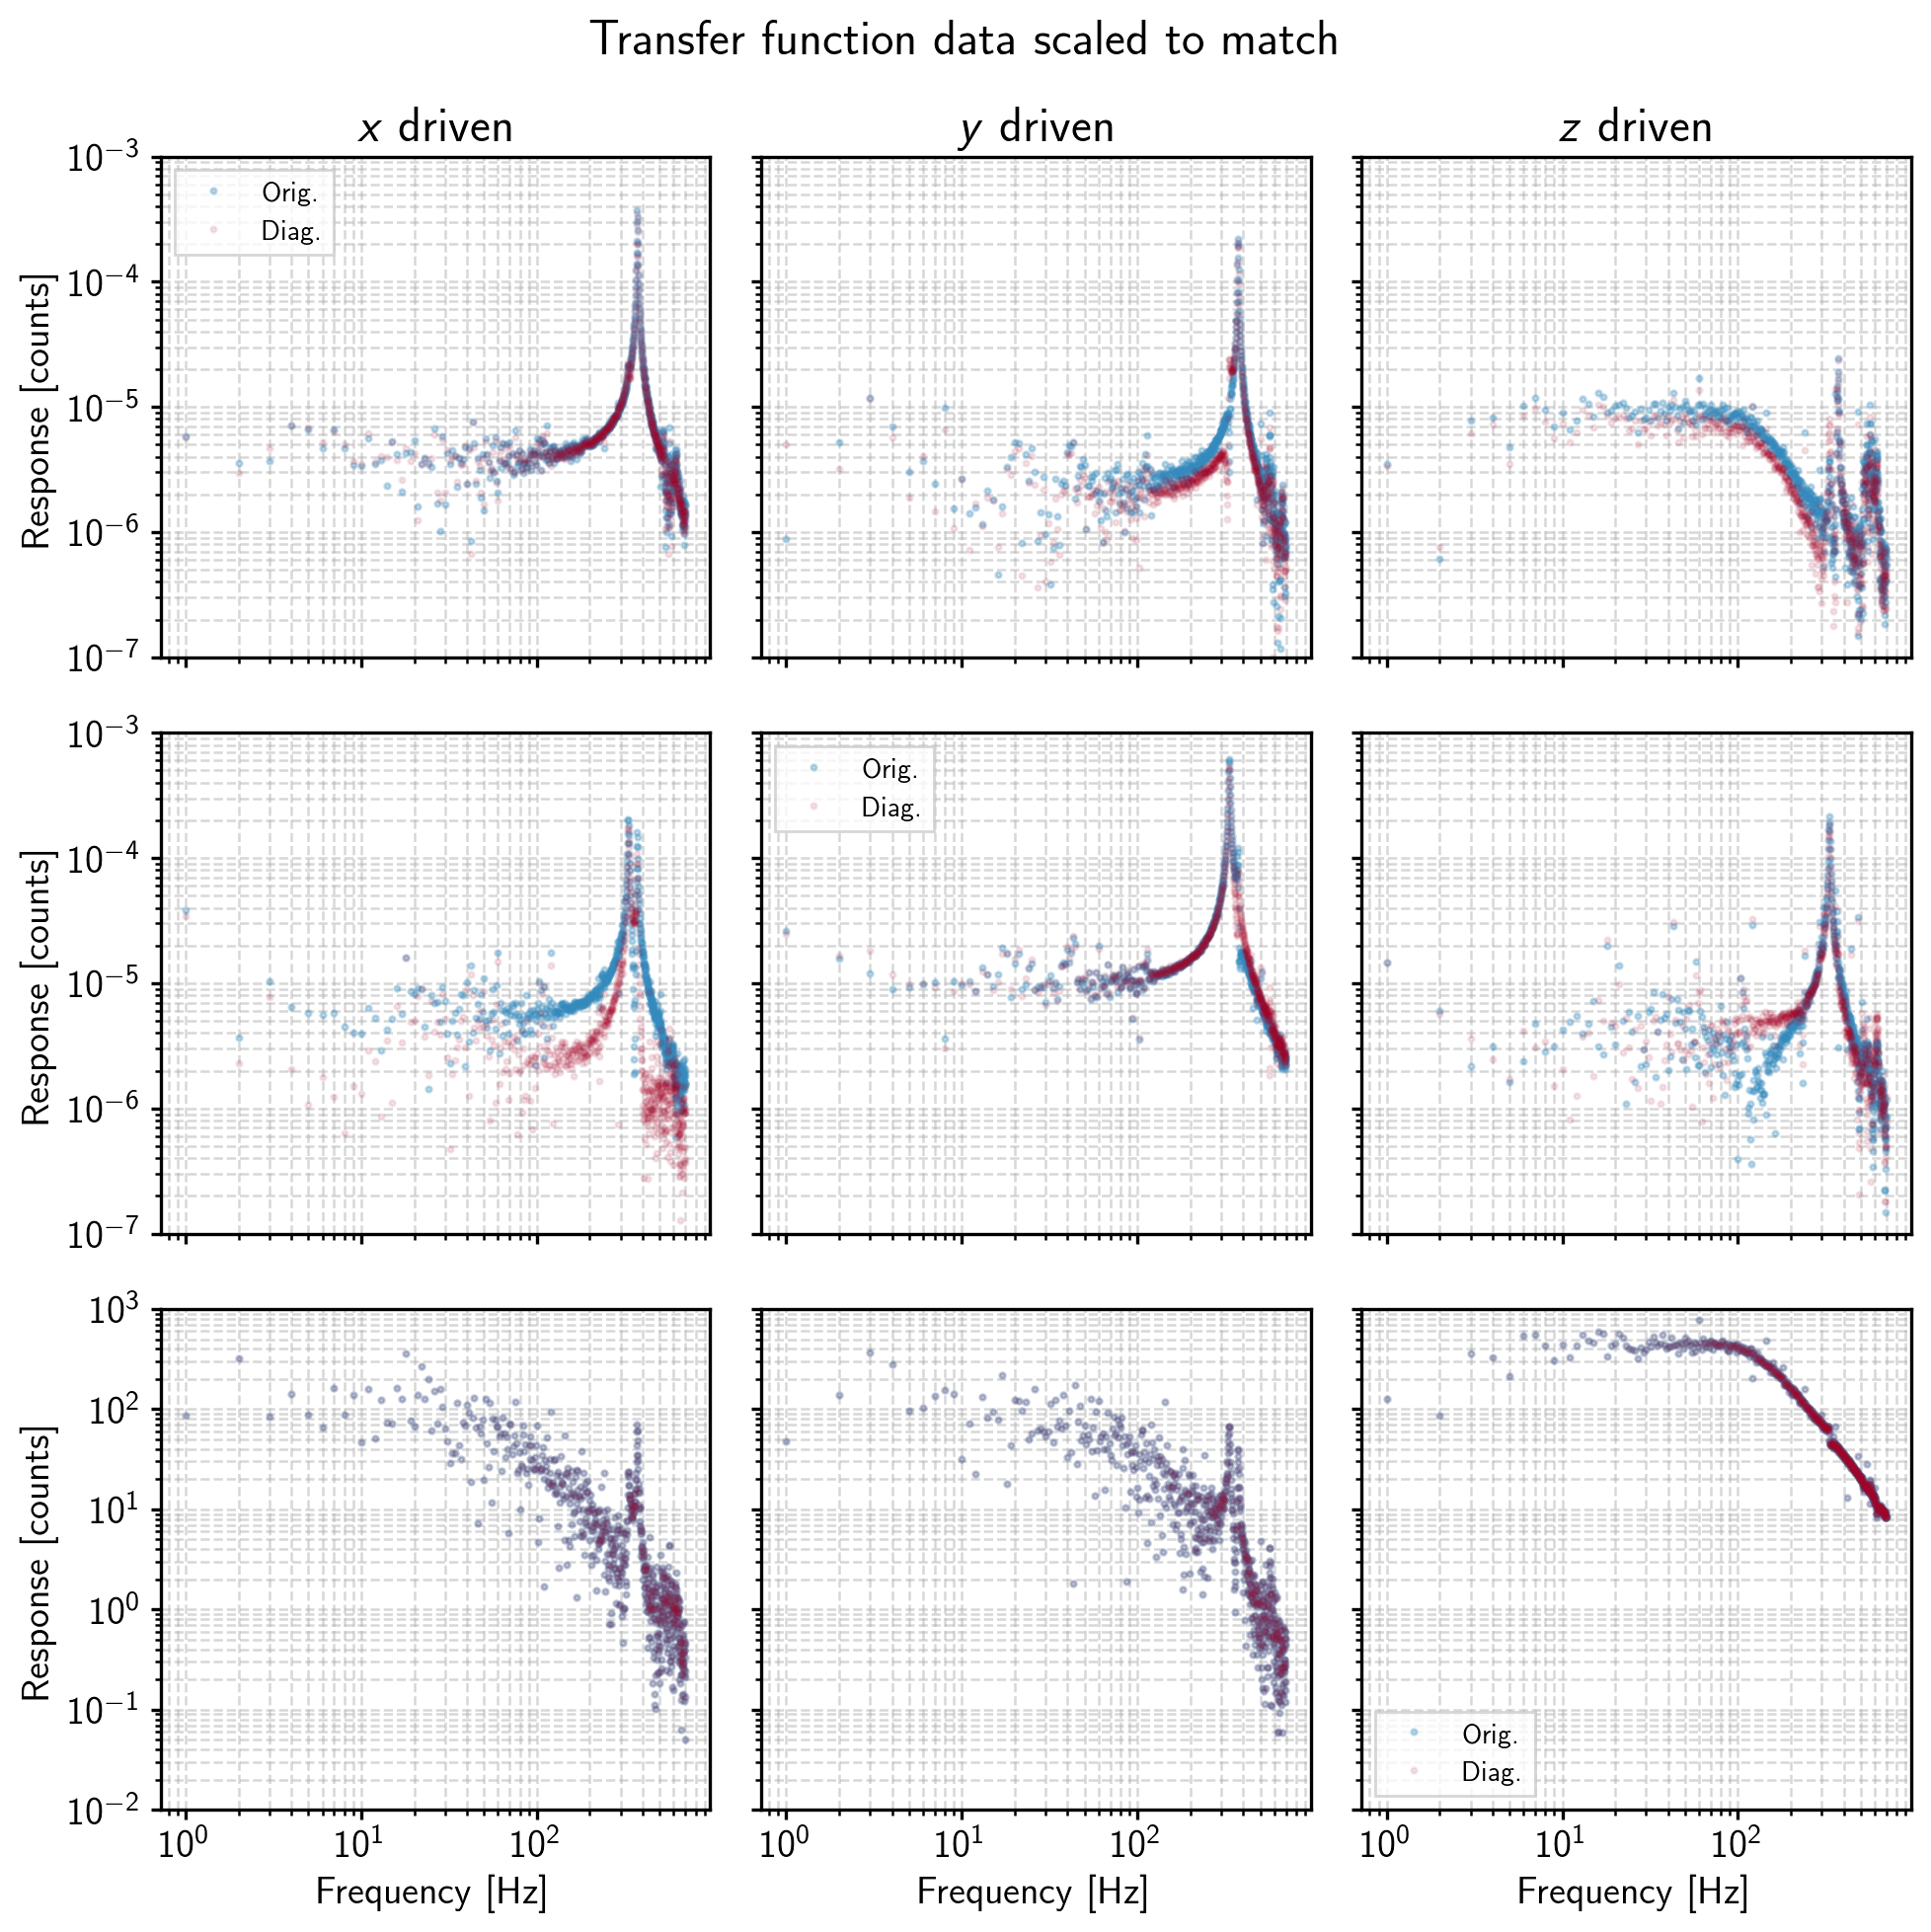

In [7]:
fig,ax = plt.subplots(3,3,figsize=(10,10),sharex=True,sharey='row')

ratios = np.zeros((3))
for i in range(3):
    naiv_counts = np.mean(np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,i,flat_inds]))
    diag_counts = np.mean(np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,i,flat_inds]))
    # peak_ind = np.argmax(np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,i,flat_inds]))
    # naiv_counts = np.mean(np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,i,flat_inds])[peak_ind-2:peak_ind+2])
    # diag_counts = np.mean(np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,i,flat_inds])[peak_ind-2:peak_ind+2])
    ratios[i] = naiv_counts/diag_counts

# i indexes the drive
for i in range(3):
    # j indexes the response
    for j in range(3):
        ax[j,i].loglog(freqs,np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.3,lw=0.5,ls='none',marker='o',ms=2,label='Orig.')
        ax[j,i].loglog(freqs,ratios[j]*np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.1,lw=0.5,ls='none',marker='o',ms=2,label='Diag.')
        if j<2:
            ax[j,i].set_ylim([1e-7,1e-3])
            if j==0:
                ax[j,i].set_title(titles[i])
        else:
            ax[j,i].set_ylim([1e-2,1e3])
            ax[j,i].set_xlabel('Frequency [Hz]')
        if i==0:
            ax[j,i].set_ylabel('Response [counts]')
        ax[j,i].grid(which='both')
    ax[i,i].legend()
fig.suptitle('Transfer function data scaled to match')

### Plot the raw TF responses in Newtons before applying the correction

Text(0.5, 0.98, 'Calibrated TF data before and uncalibrated TF data after diagonalization')

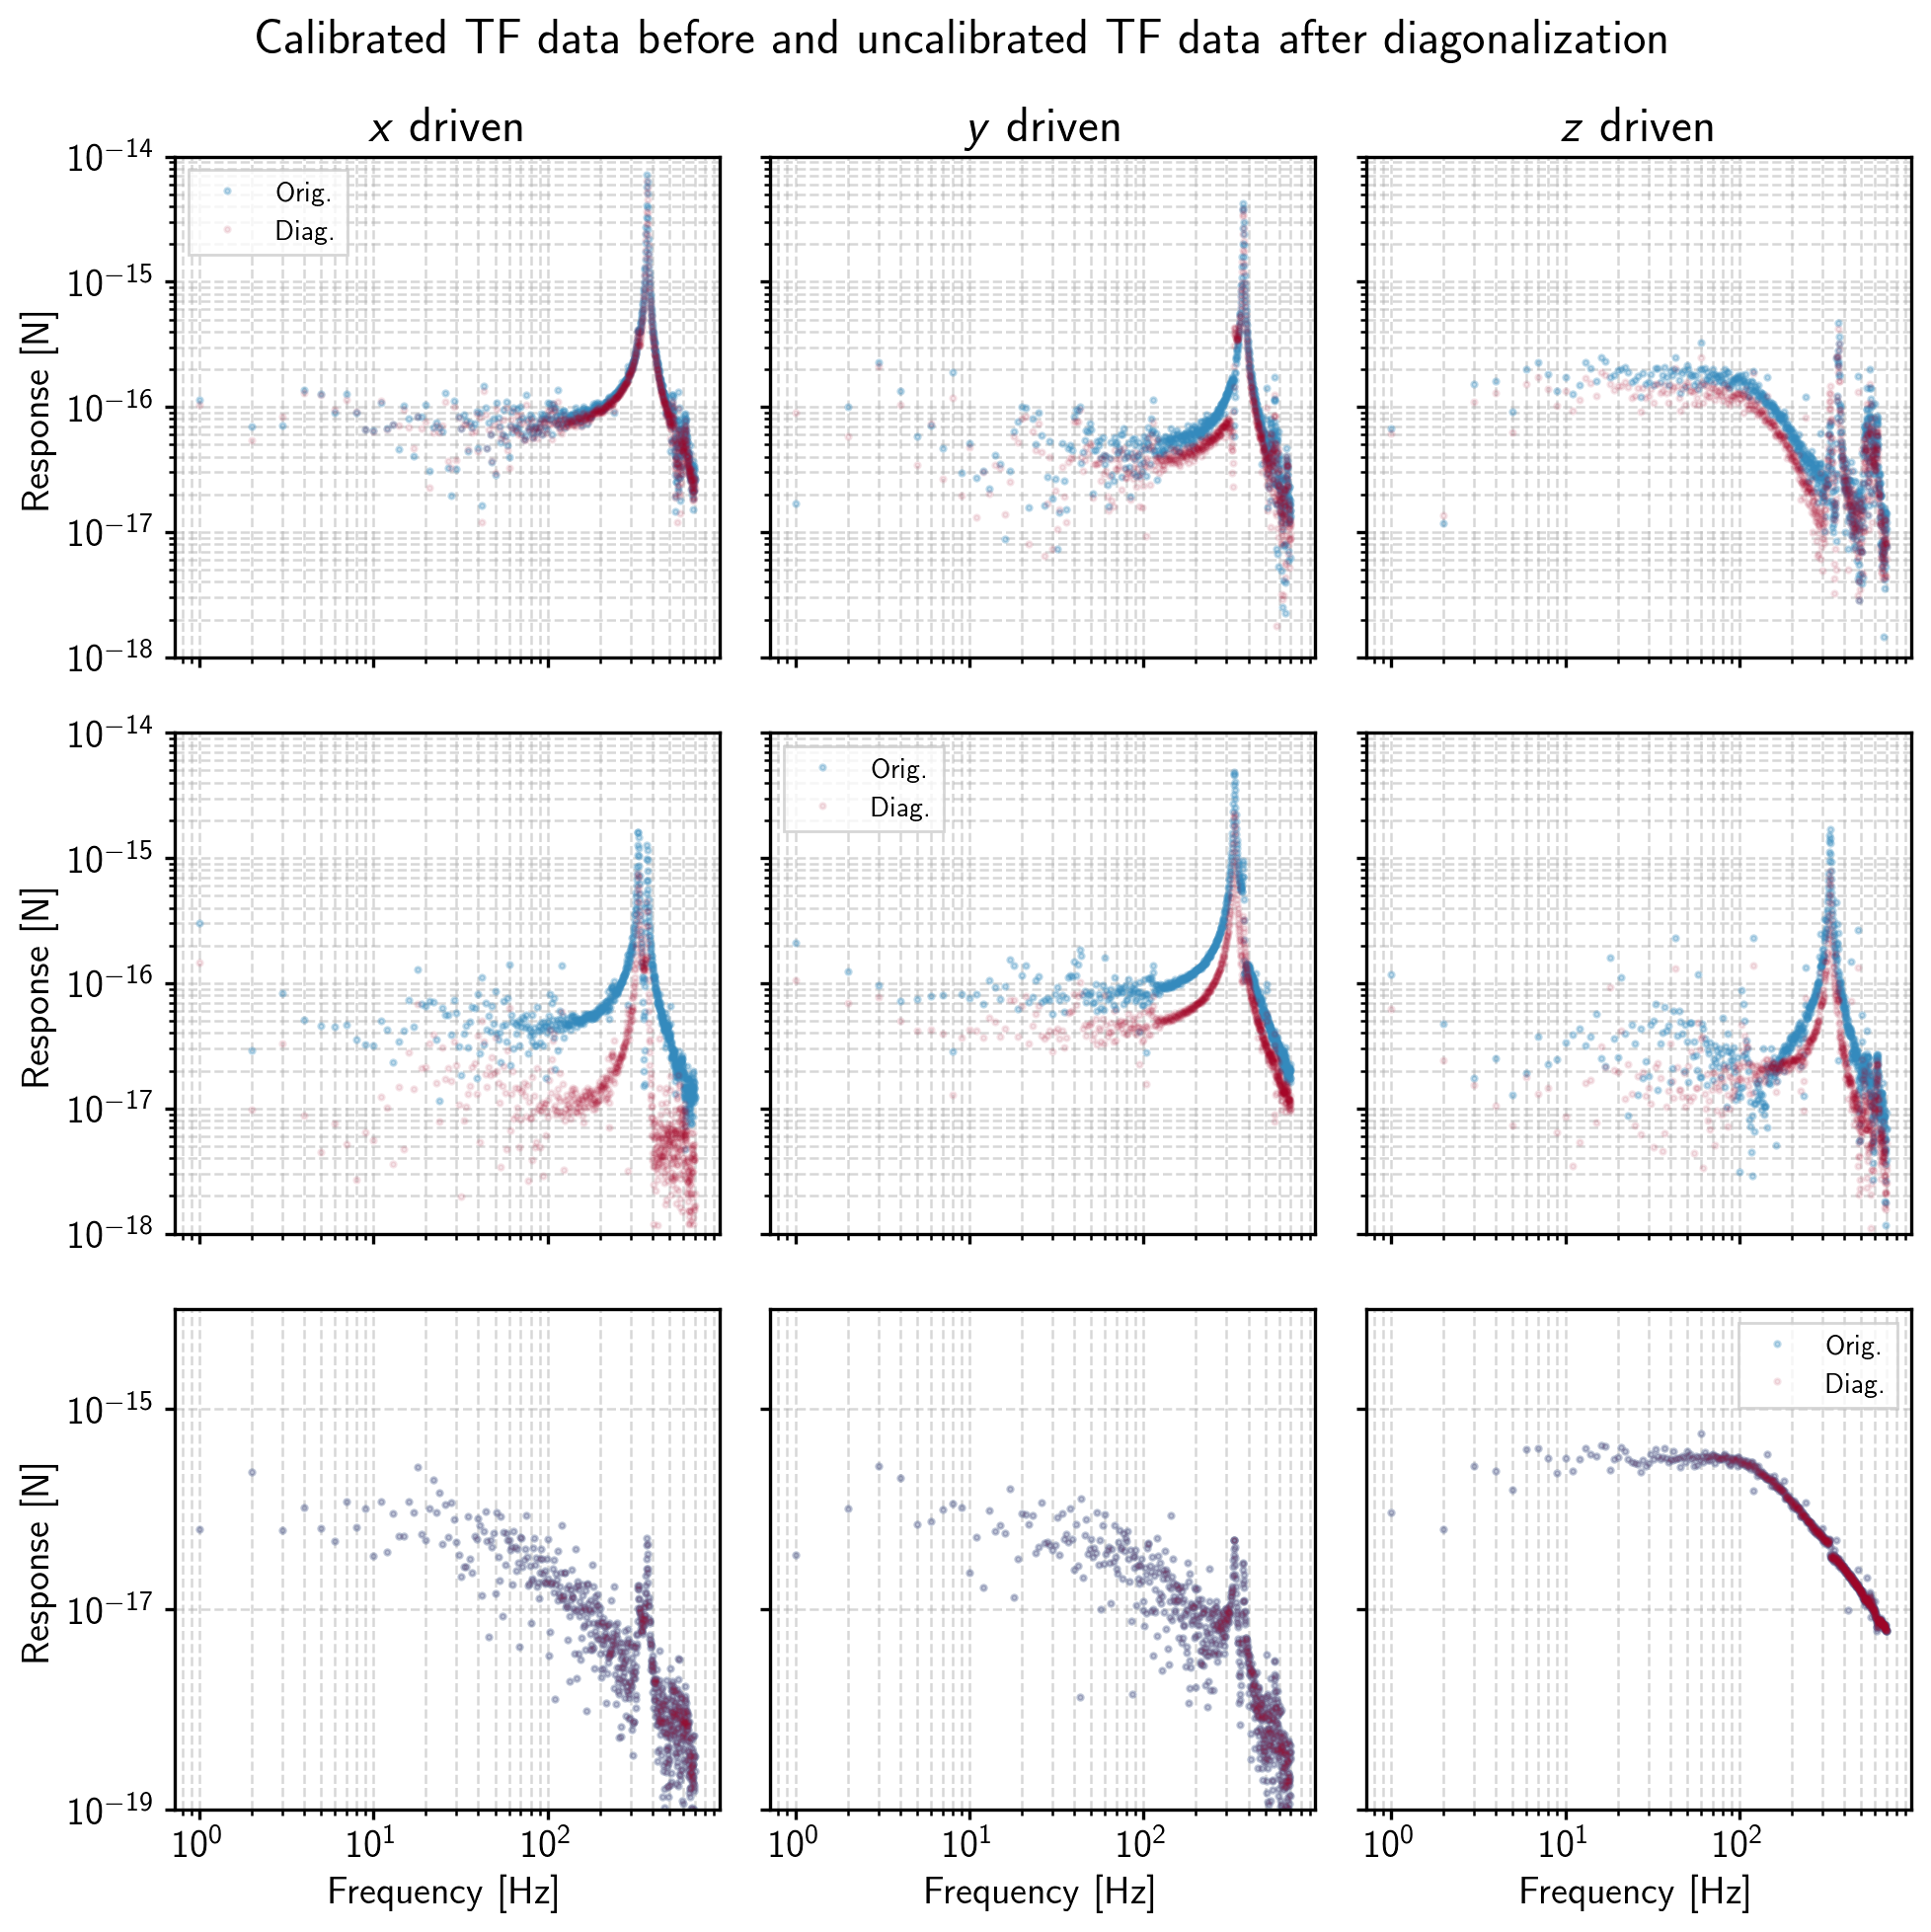

In [8]:
path = '/data/new_trap_processed/calibrations/transfer_funcs/{}/TF.h5'.format(date)

naiv_scale_factors = np.zeros((3))
diag_scale_factors = np.zeros((3))

with h5py.File(path,'r') as tf_file:
    for i in range(3):
        naiv_scale_factors[i] = tf_file.attrs['scaleFactors_QPD'][i]
        diag_scale_factors[i] = tf_file.attrs['scaleFactors_QPD'][i]*ratios[i]

fig,ax = plt.subplots(3,3,figsize=(10,10),sharex=True,sharey='row')

# i indexes the drive
for i in range(3):
    # j indexes the response
    for j in range(3):
        ax[j,i].loglog(freqs,naiv_scale_factors[j]*np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.3,lw=0.5,ls='none',marker='o',ms=2,label='Orig.')
        ax[j,i].loglog(freqs,naiv_scale_factors[j]*np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.1,lw=0.5,ls='none',marker='o',ms=2,label='Diag.')
        if j<2:
            ax[j,i].set_ylim([1e-18,1e-14])
            if j==0:
                ax[j,i].set_title(titles[i])
        else:
            ax[j,i].set_ylim([1e-19,1e-14])
            ax[j,i].set_xlabel('Frequency [Hz]')
        if i==0:
            ax[j,i].set_ylabel('Response [N]')
        ax[j,i].grid(which='both')
    ax[i,i].legend()
fig.suptitle('Calibrated TF data before and uncalibrated TF data after diagonalization')

### Apply the correction to the scaling and plot the resonses again

Text(0.5, 0.98, 'Calibrated TF data before and after diagonalization')

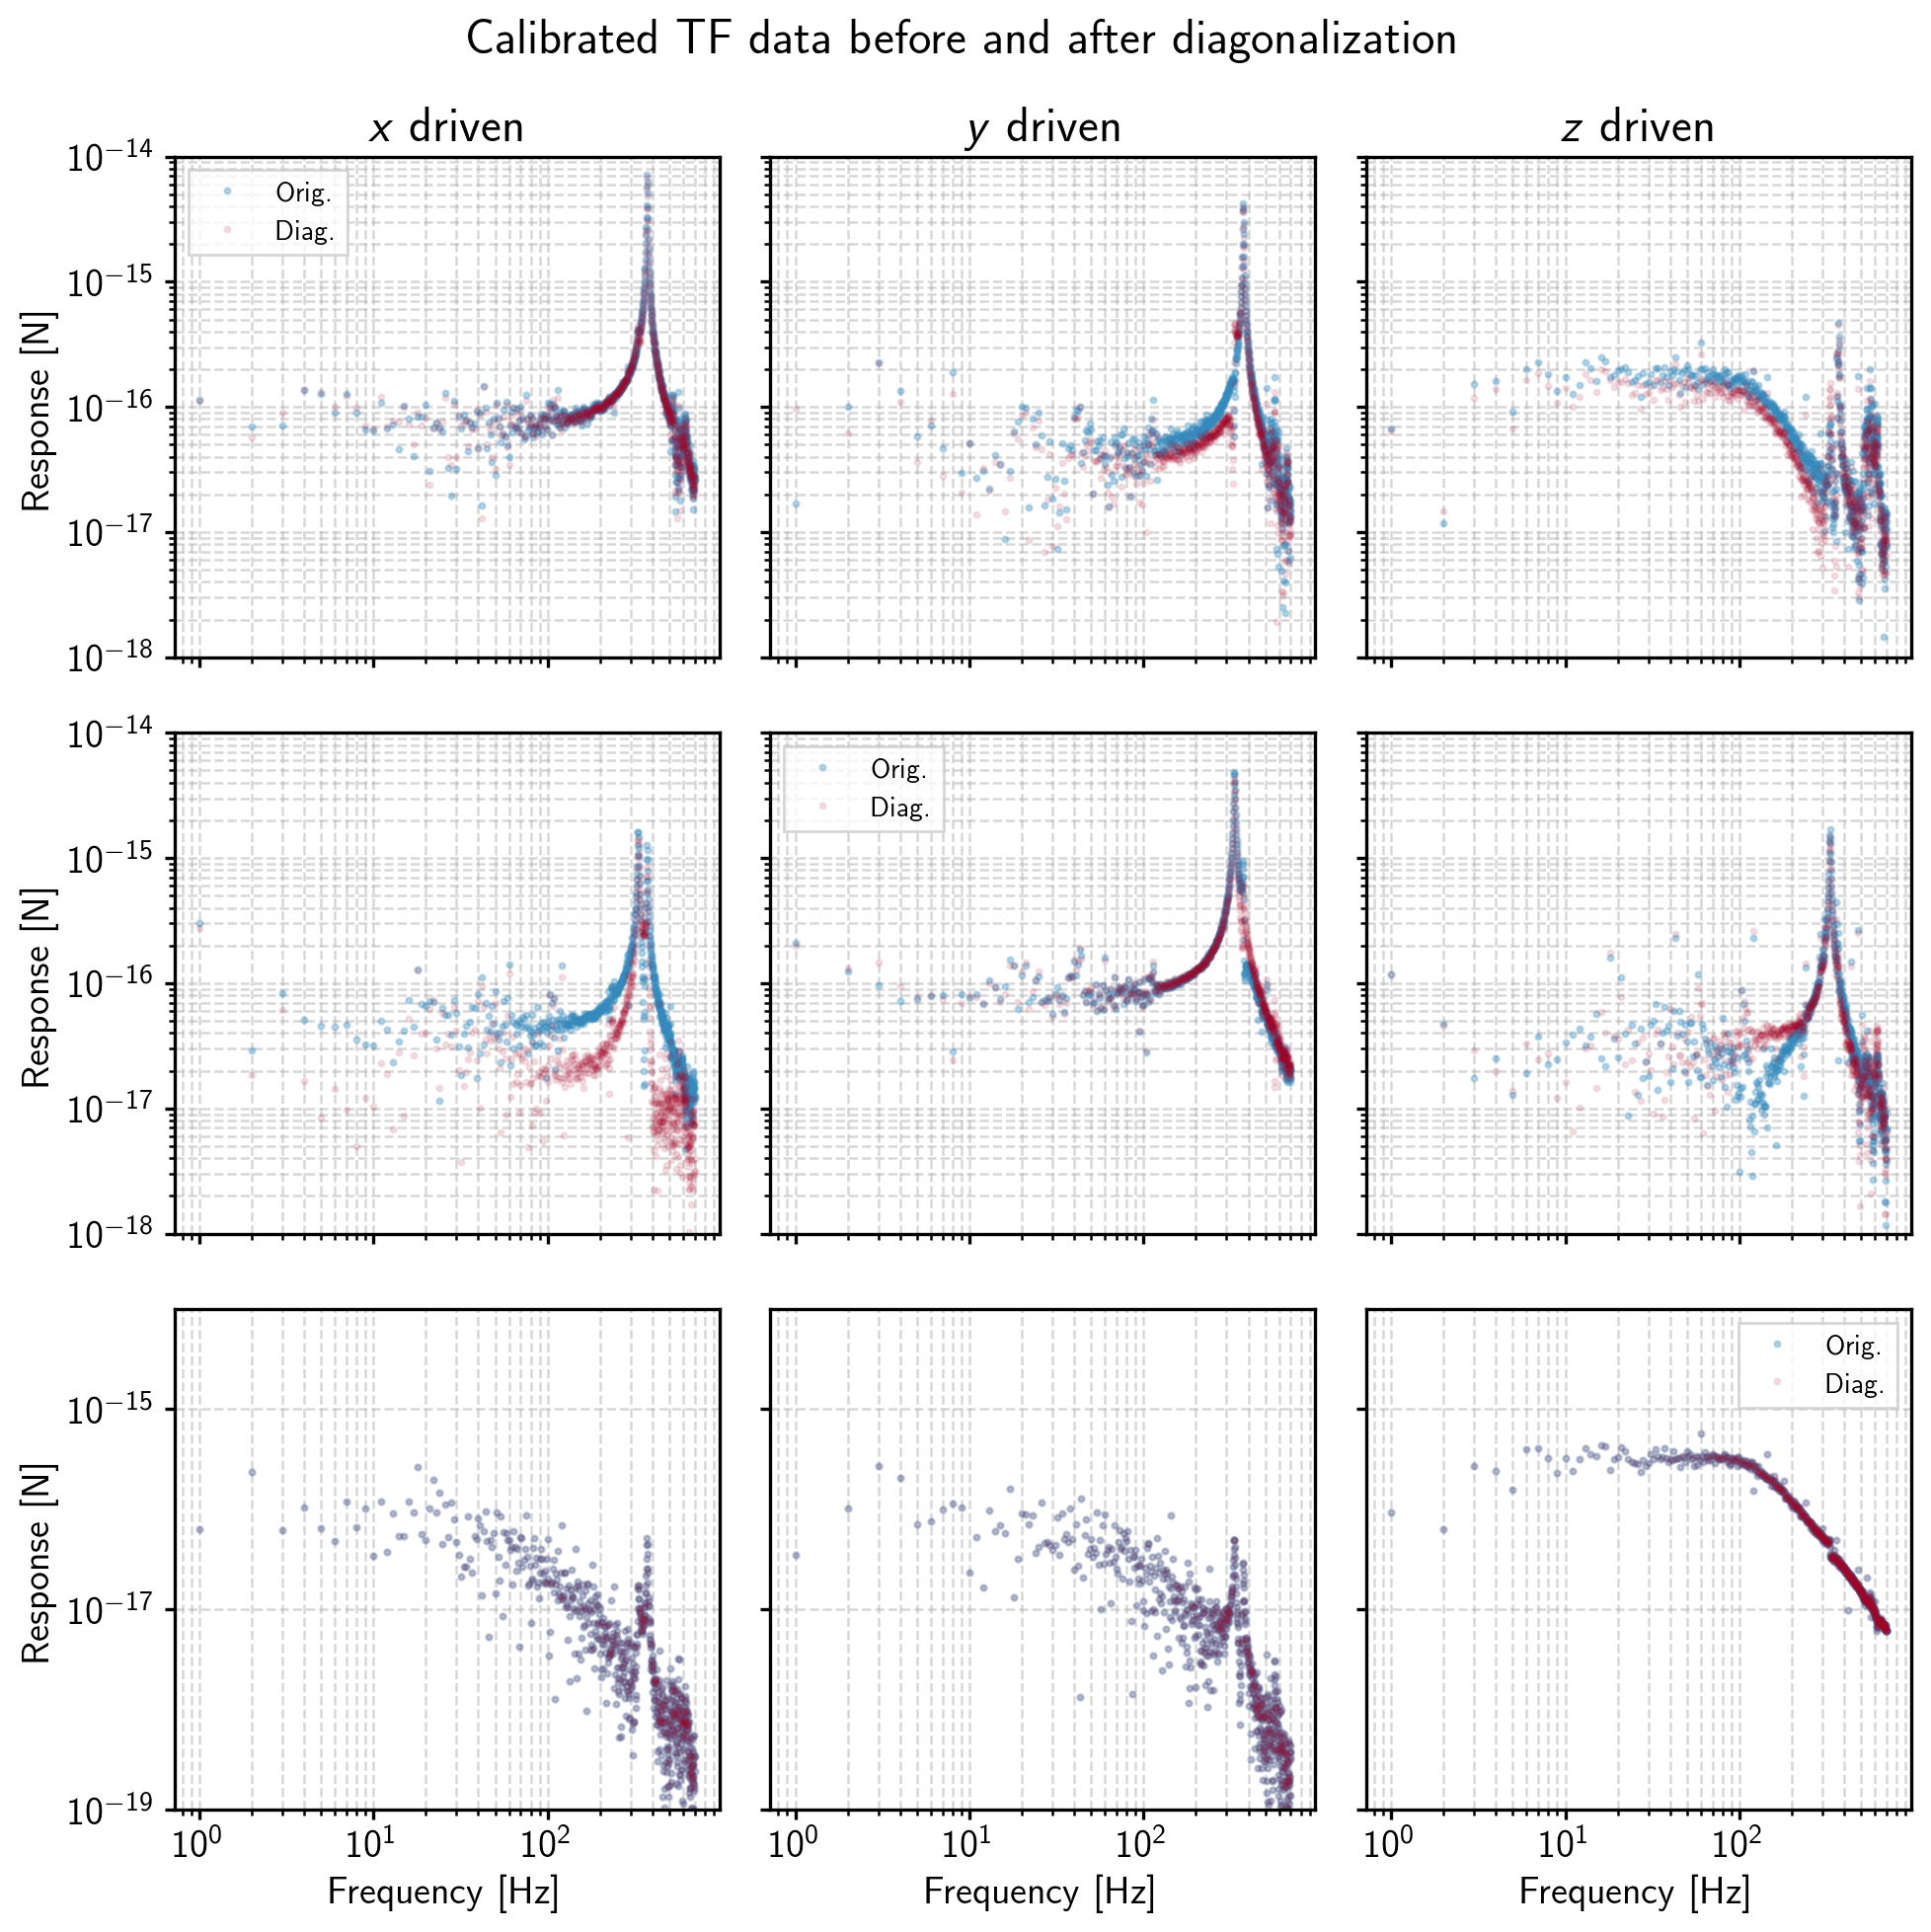

In [9]:
fig,ax = plt.subplots(3,3,figsize=(10,10),sharex=True,sharey='row')

# i indexes the drive
for i in range(3):
    # j indexes the response
    for j in range(3):
        ax[j,i].loglog(freqs,naiv_scale_factors[j]*np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.3,lw=0.5,ls='none',marker='o',ms=2,label='Orig.')
        ax[j,i].loglog(freqs,diag_scale_factors[j]*np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,j,freq_inds]),alpha=0.1,lw=0.5,ls='none',marker='o',ms=2,label='Diag.')
        if j<2:
            ax[j,i].set_ylim([1e-18,1e-14])
            if j==0:
                ax[j,i].set_title(titles[i])
        else:
            ax[j,i].set_ylim([1e-19,1e-14])
            ax[j,i].set_xlabel('Frequency [Hz]')
        if i==0:
            ax[j,i].set_ylabel('Response [N]')
        ax[j,i].grid(which='both')
    ax[i,i].legend()
fig.suptitle('Calibrated TF data before and after diagonalization')

### Plot the dimensionless responses in Newtons/Newton

Text(0.5, 0.98, 'Dimensionless responses before and after diagonalization')

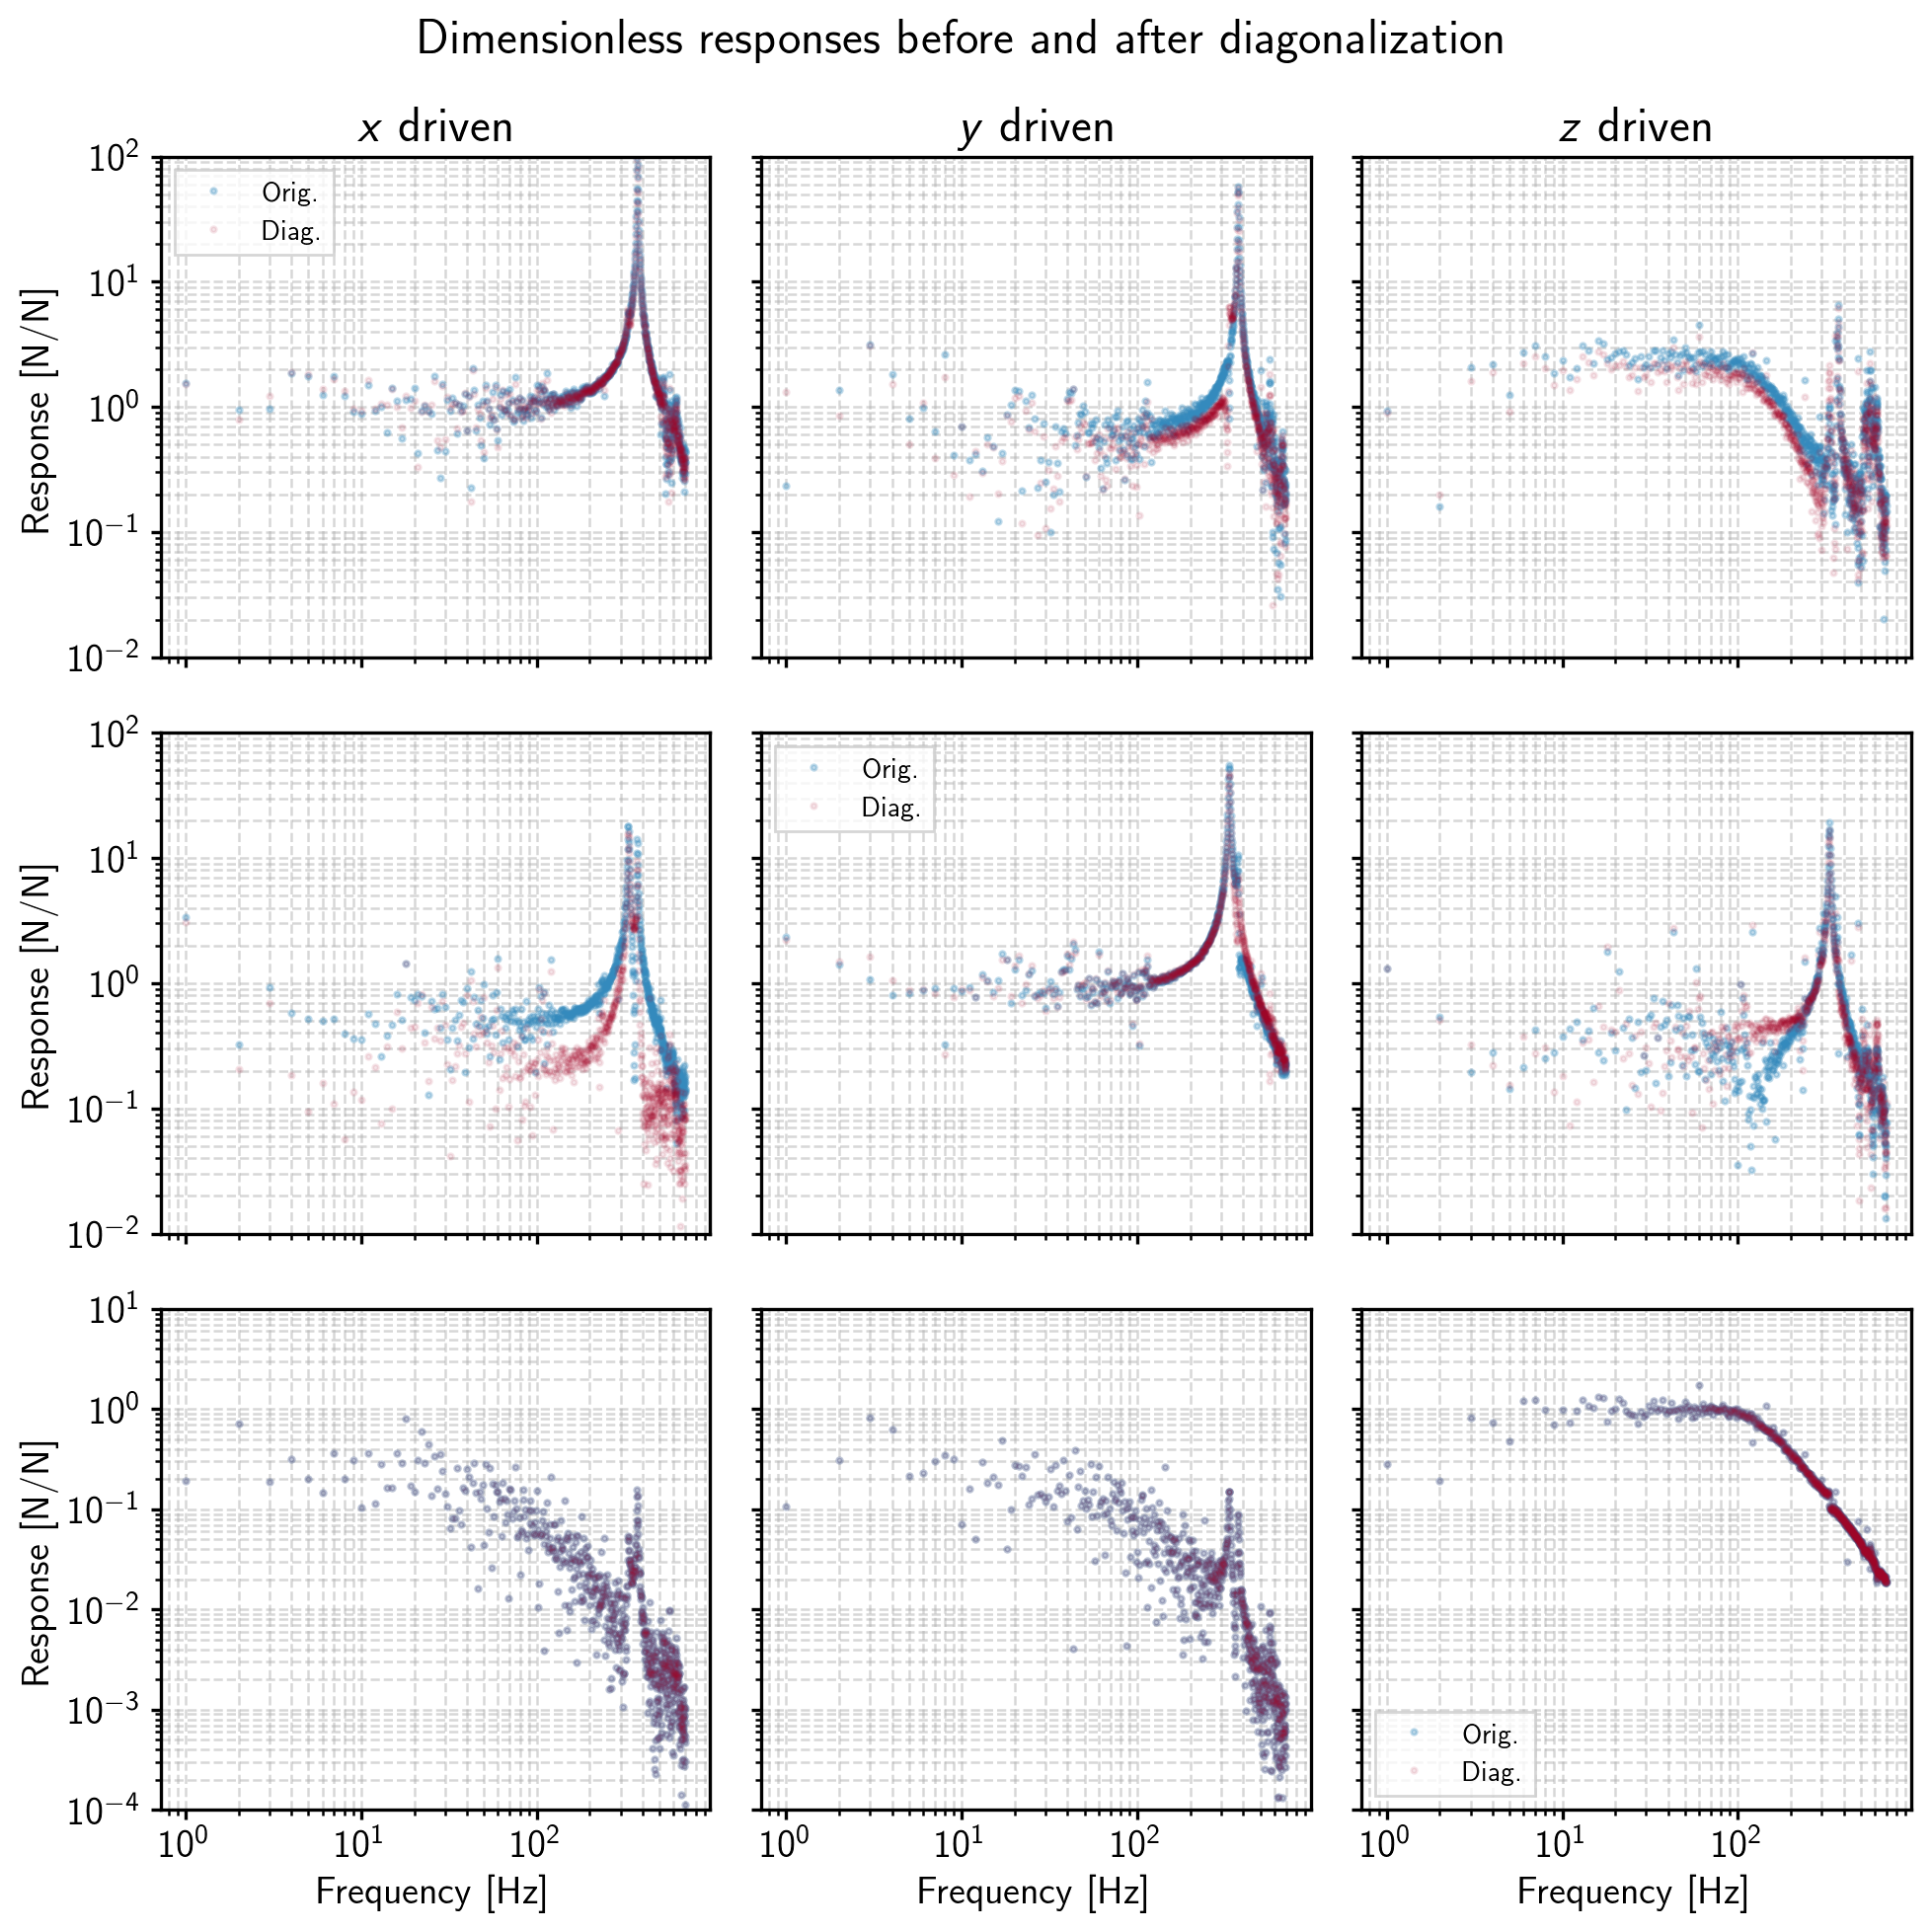

In [10]:
fig,ax = plt.subplots(3,3,figsize=(10,10),sharex=True,sharey='row')

drive_force = np.zeros(3)
for i in range(3):
    drive_force[i] = np.mean(np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,i,flat_inds]))*naiv_scale_factors[i]

# i indexes the drive
for i in range(3):
    # j indexes the response
    for j in range(3):
        ax[j,i].loglog(freqs,naiv_scale_factors[j]*np.abs(aggdat_naiv.agg_dict['qpd_ffts_full'][i,j,freq_inds])/drive_force[j],\
                       alpha=0.3,lw=0.5,ls='none',marker='o',ms=2,label='Orig.')
        ax[j,i].loglog(freqs,diag_scale_factors[j]*np.abs(aggdat_diag.agg_dict['qpd_ffts_full'][i,j,freq_inds])/drive_force[j],\
                       alpha=0.1,lw=0.5,ls='none',marker='o',ms=2,label='Diag.')
        if j<2:
            ax[j,i].set_ylim([1e-2,1e2])
            if j==0:
                ax[j,i].set_title(titles[i])
        else:
            ax[j,i].set_ylim([1e-4,1e1])
            ax[j,i].set_xlabel('Frequency [Hz]')
        if i==0:
            ax[j,i].set_ylabel('Response [N/N]')
        ax[j,i].grid(which='both')
    ax[i,i].legend()
fig.suptitle('Dimensionless responses before and after diagonalization')

### Run a script with sudo privileges to save the new scale factors to the TF.h5 file
Enter password at the prompt.

In [54]:
password = getpass.getpass()
command = ' '.join(['/home/clarkeh/.conda/envs/clarkeh/bin/python /home/clarkeh/OptLevAnalysis/scripts/diagonalized_tf.py',path] + \
                   ['{:.8e}'.format(s) for s in diag_scale_factors])
!echo {password}|sudo -S {command}
del password

[sudo] password for clarkeh: 
Wrote new scale factors to file /data/new_trap_processed/calibrations/transfer_funcs/20231109/TF.h5


### Plot the result and compare to the previous TF plot

Text(0.5, 0.98, 'Transfer function magnitudes for the QPD without diagonalization')

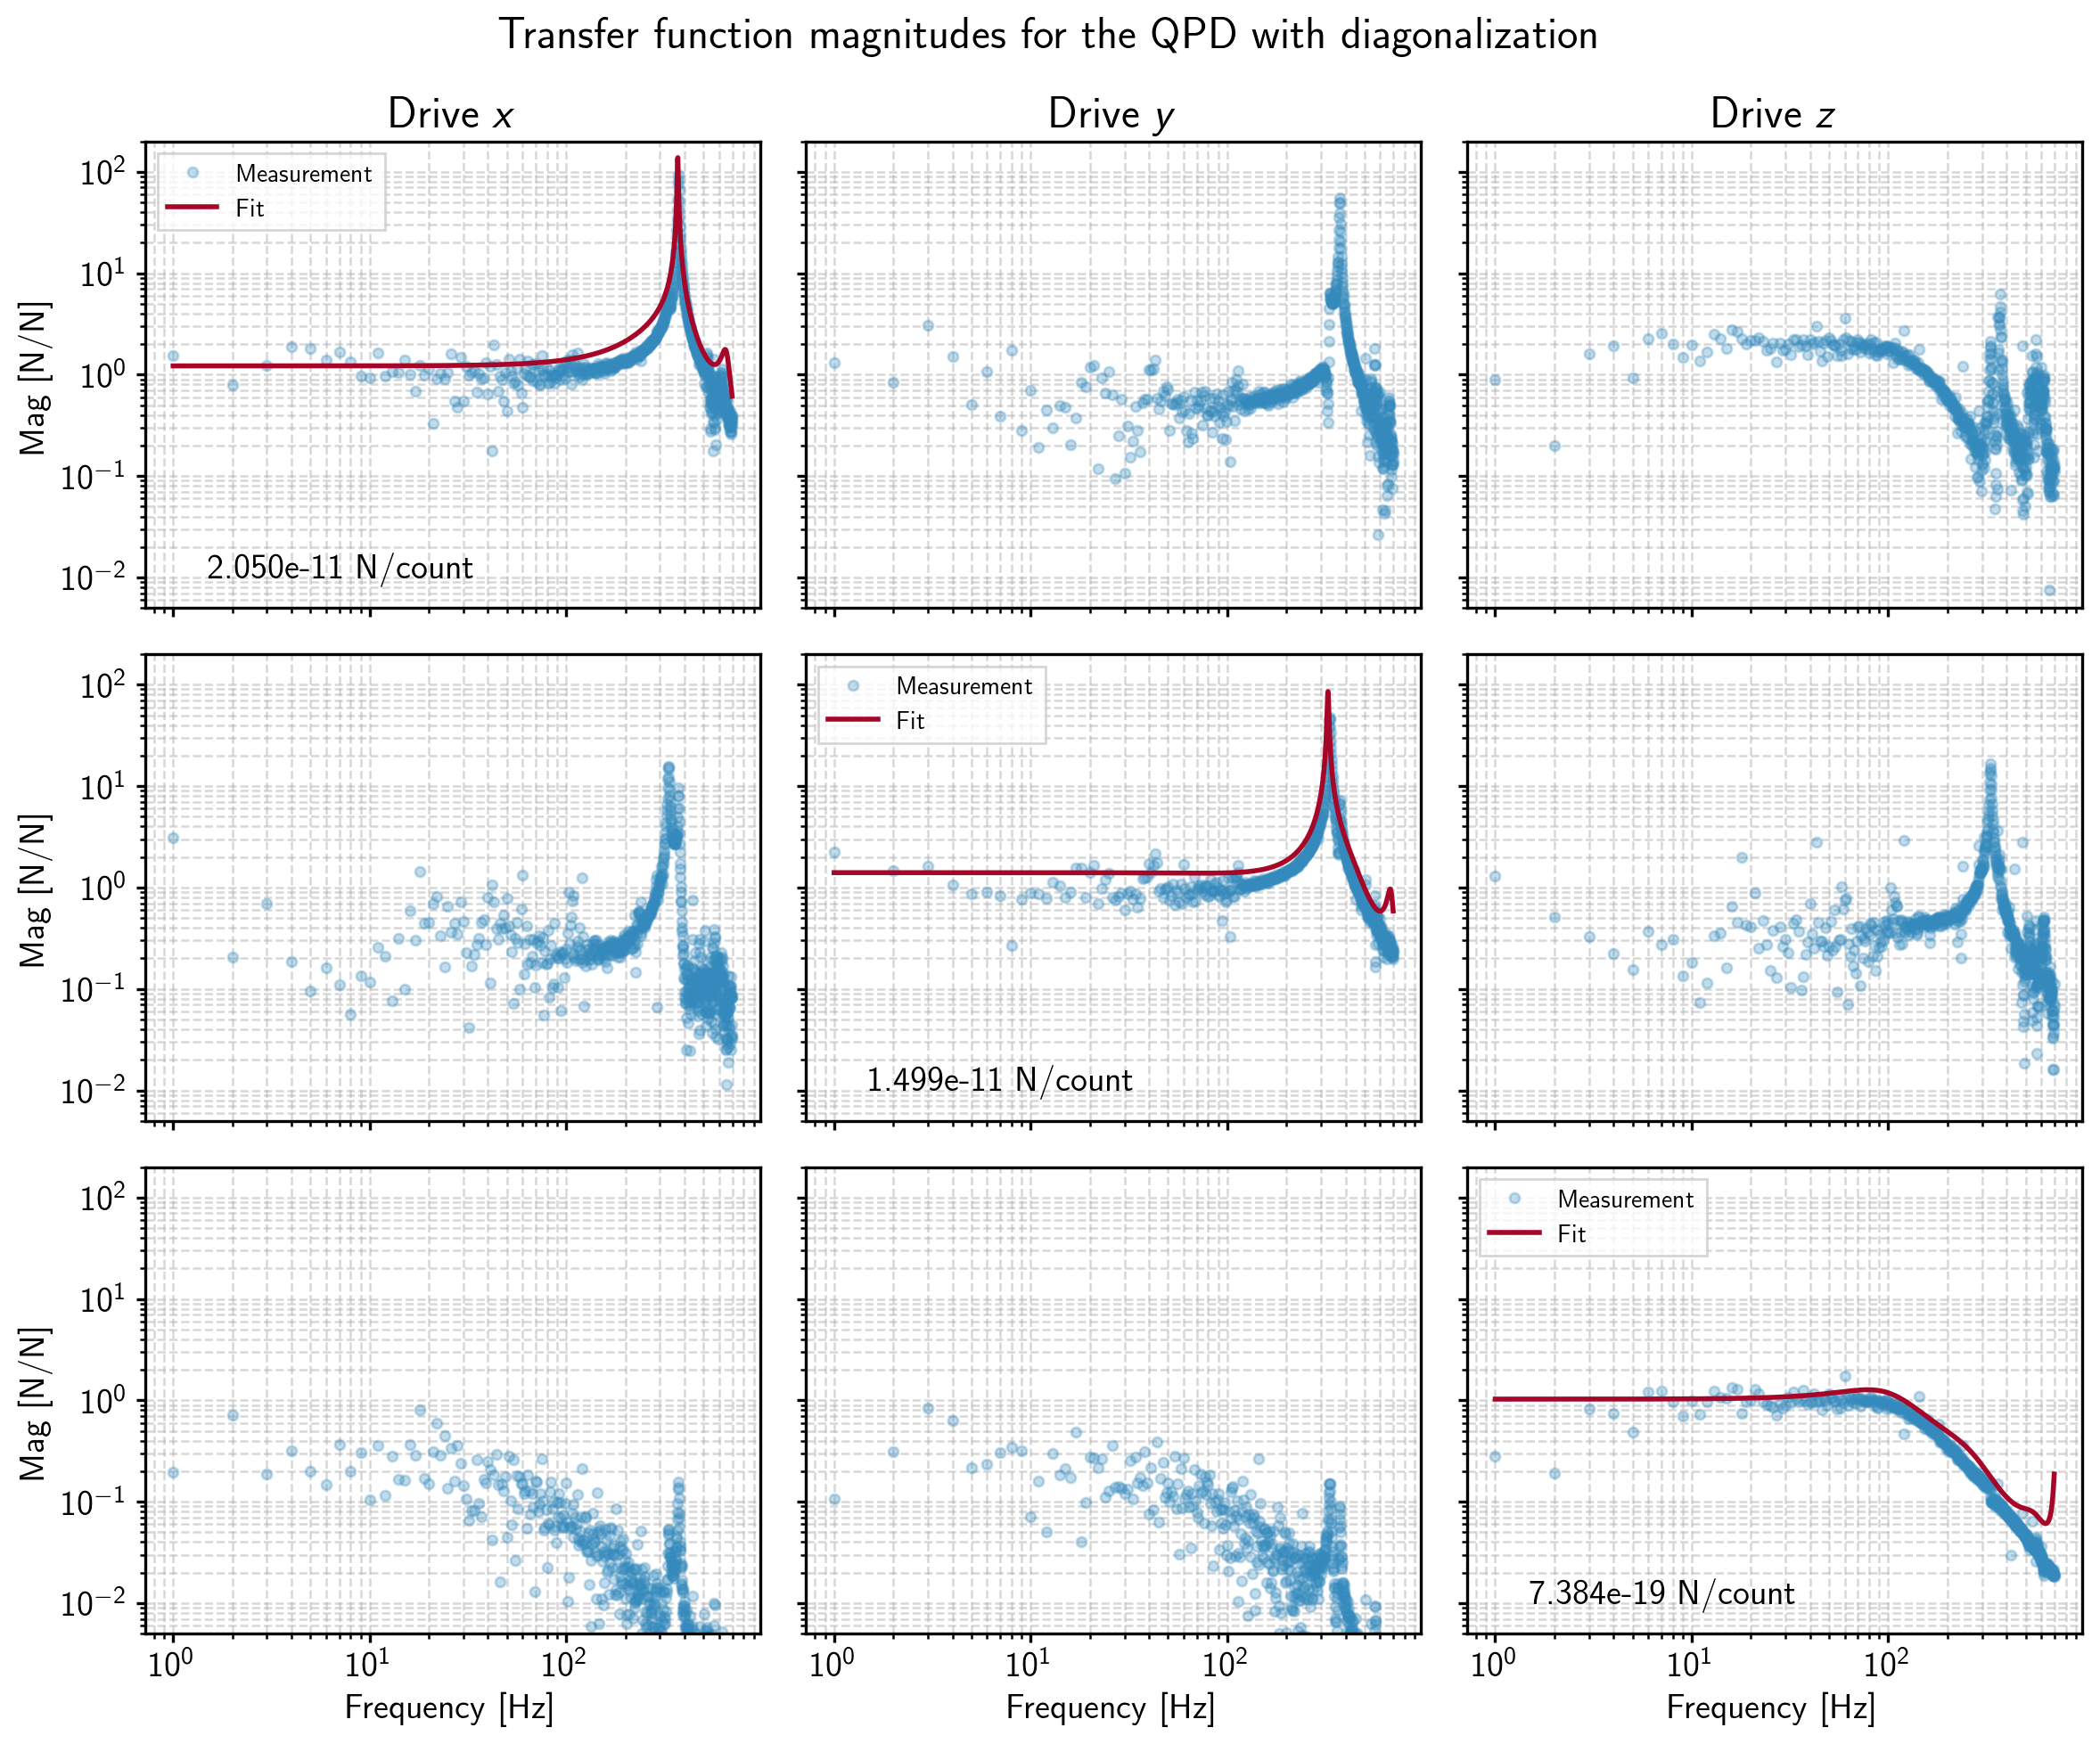

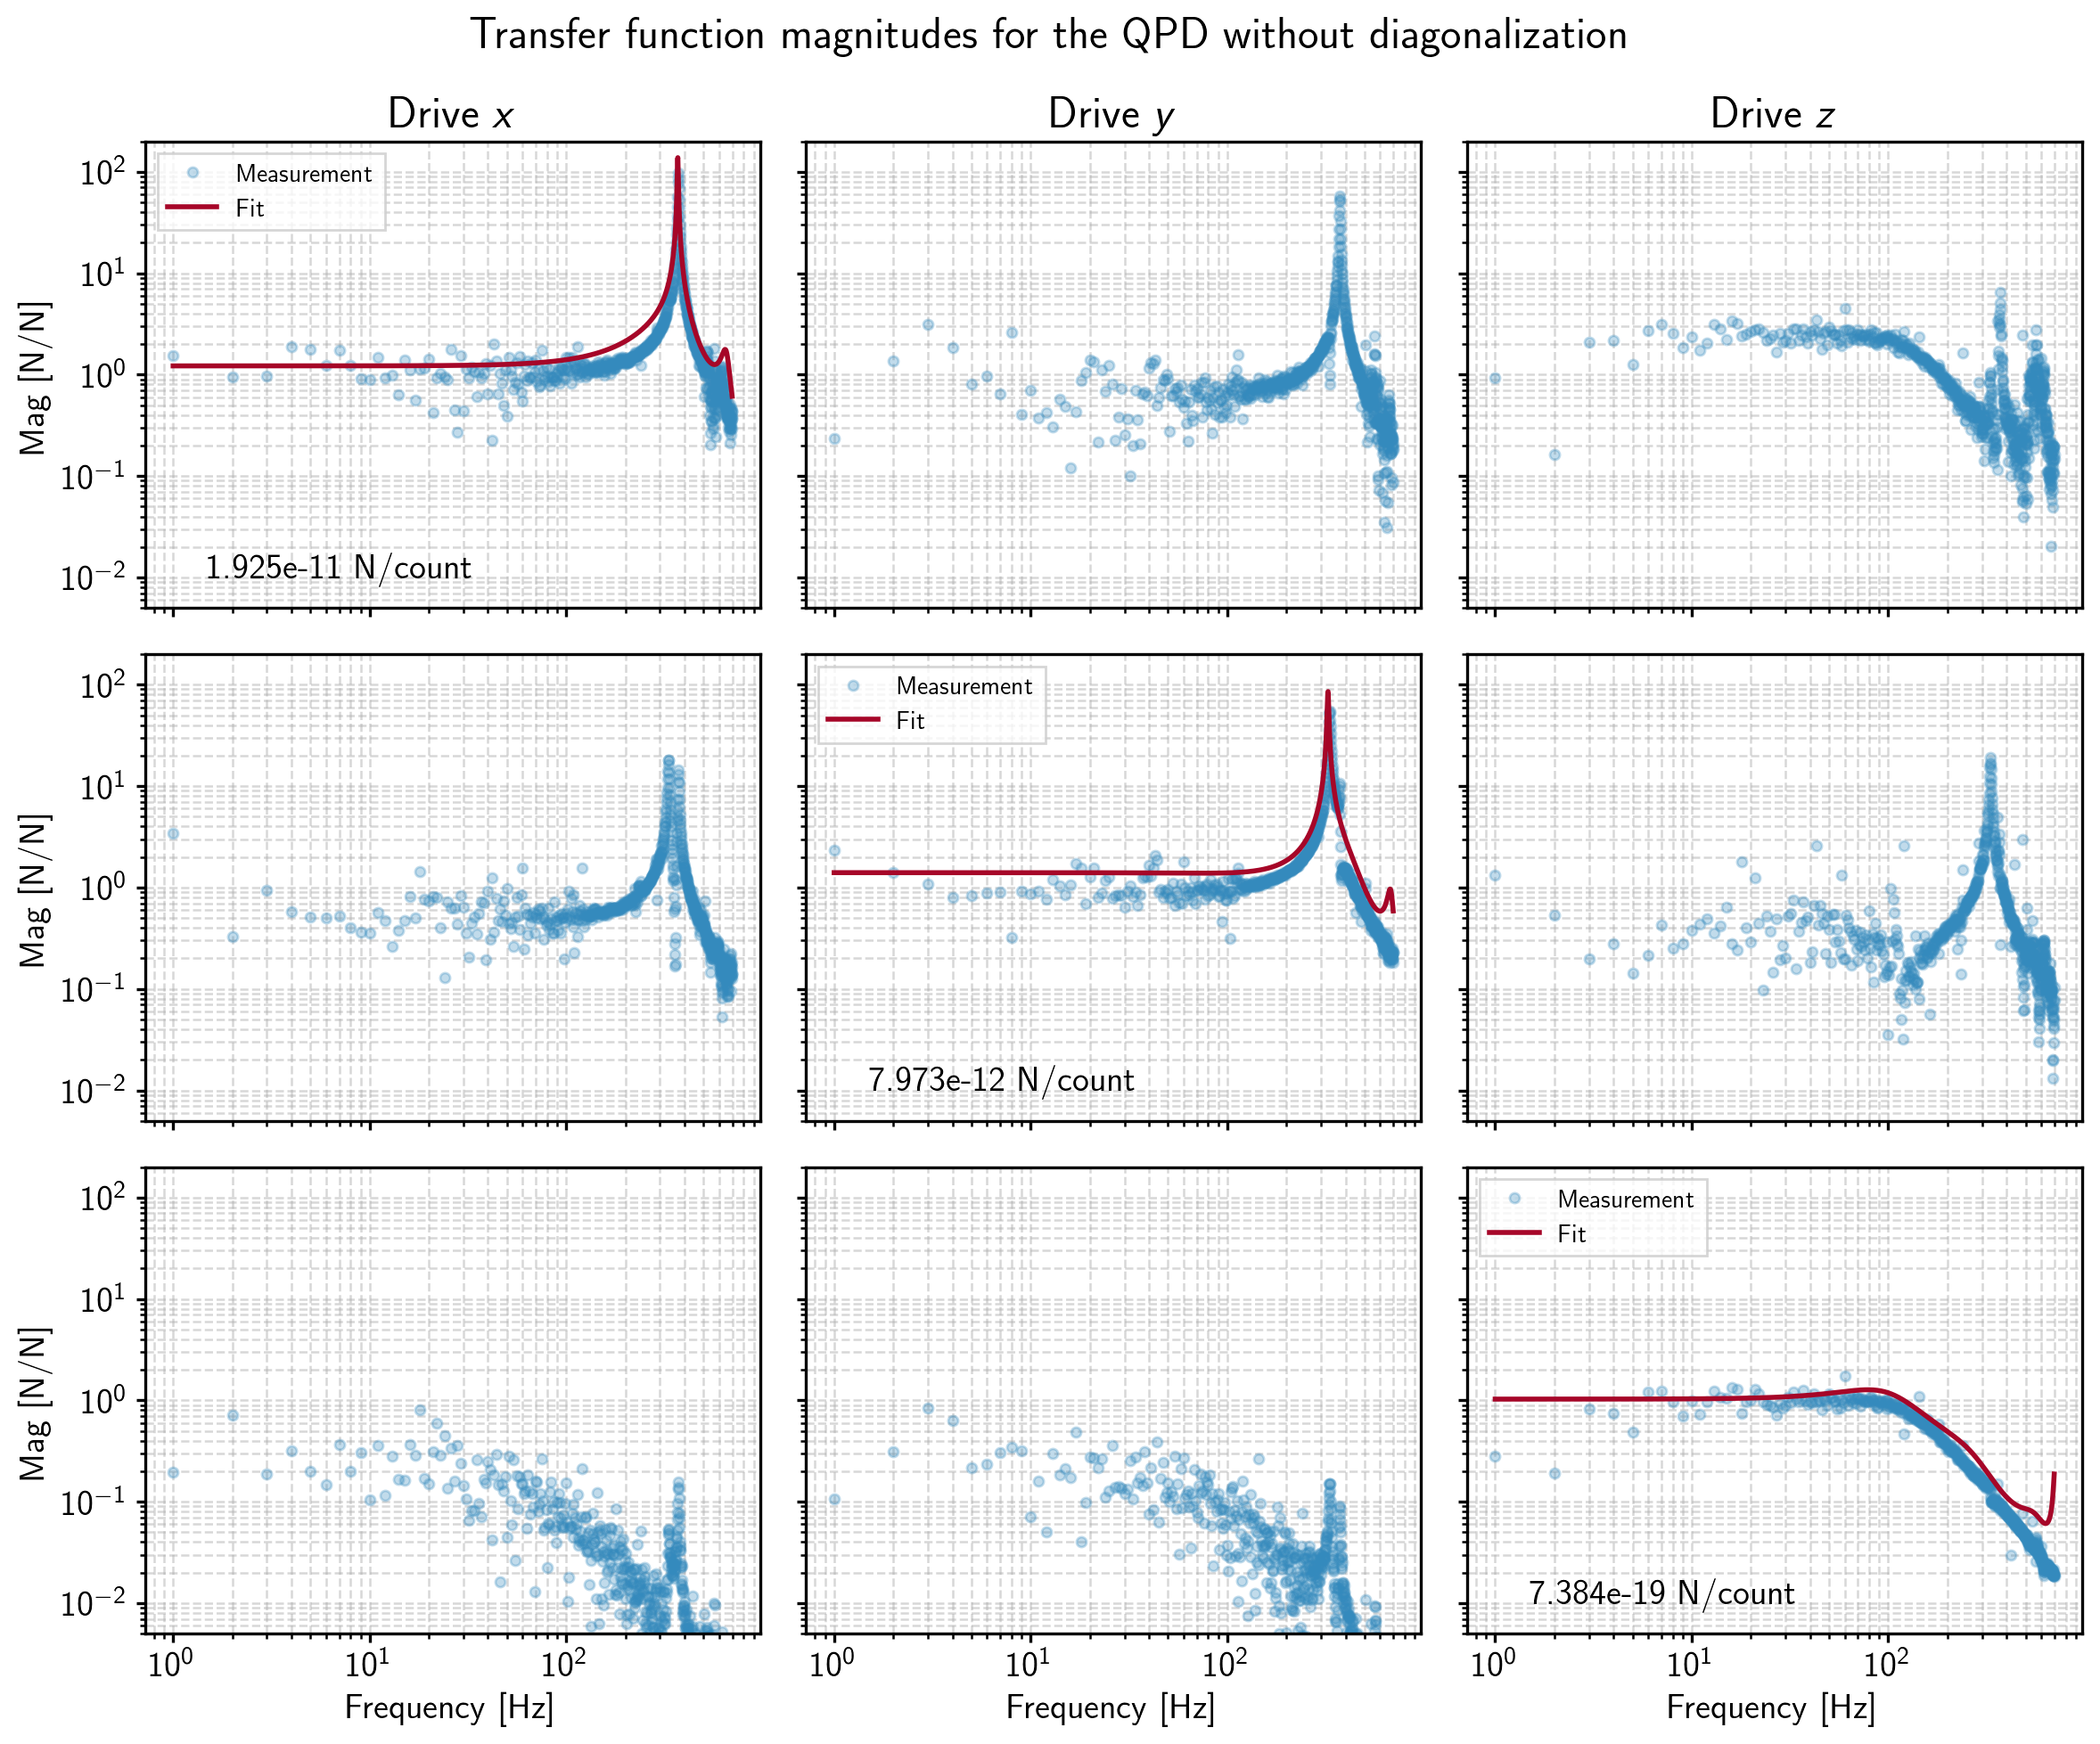

In [11]:
fig1,ax1 = pl.transfer_funcs(path,diagonalize_qpd=True,agg_dict=aggdat_diag.agg_dict)
fig1.suptitle(fig1._suptitle.get_text()+' with diagonalization')
fig2,ax2 = pl.transfer_funcs(path,diagonalize_qpd=False,agg_dict=aggdat_naiv.agg_dict)
fig2.suptitle(fig2._suptitle.get_text()+' without diagonalization')